In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from neuraldistributions.models import transforms
from neuraldistributions.datasets import static

from multiprocessing import Pool

import os
device = "cuda"

dataport not available, will only be able to load data locally


In [2]:
import numpy as np
import torch

from neuraldistributions.datasets import mouse_static_loaders, extract_data_key
from neuraldistributions.models import poisson, zig, flowfa, ziffa, flowfa_ident
from neuraldistributions.trainers import base_trainer
from neuraldistributions.utility import get_loglikelihood

In [3]:
random_seed=42
dataset_dir = "../project/data"
datasets = [
    "static_edited_dsampled.zip",
]
scan_id = [2, 1]
dataset_paths = [f"{dataset_dir}/{dataset}" for dataset in datasets]
areas = [["V1", "LM"]]
neurons_ns = [1000, 907]

In [4]:
dataset_index = 0
dataset_path = dataset_paths[dataset_index]
data_key = extract_data_key(dataset_path)
area = areas[dataset_index]
neurons_n = neurons_ns[dataset_index]

dataset_config = {
    "paths": [dataset_path],
    "seed": random_seed,
    "batch_size": 64,
    "area": area,
    "neurons_n": neurons_n,
    "normalize_images": True,
    "normalize_neurons": True,
    "return_more": True,
    "device": device,
    "shuffle_train": True,
}

dataloaders = mouse_static_loaders(**dataset_config)

100%|██████████| 5994/5994 [00:00<00:00, 294988.13it/s]


In [5]:
grid_mean_pred_config = {
    "type": "cortex",
    "input_dimensions": 2,
    "hidden_layers": 4,
    "hidden_features": 20,
    "nonlinearity": "ReLU",
    "final_tanh": True,
}

image_model_config = {
    "pad_input": False,
    "stack": -1,
    "layers": 4,
    "input_kern": 15,
    "gamma_input": 1,
    "gamma_readout": 2.439,
    "hidden_dilation": 1,
    "hidden_kern": 13,
    "hidden_channels": 64,
    "n_se_blocks": 0,
    "depth_separable": True,
    "share_features": False,
    "share_grid": False,
    "init_sigma": 0.4,
    "init_mu_range": 0.55,
    "gauss_type": "full",
    "grid_mean_predictor": grid_mean_pred_config,
}

In [6]:
model_name = "flowfa_ident"
d_latent = 3
sample_transform = "learned-leaky-low-rank-k-500"
mean_transform = "learned"
per_neuron_transform = True
unit_variance_constraint = False

model_config = {
    "image_model_fn": "nnsysident.models.models.se2d_fullgaussian2d",
    "image_model_config": image_model_config,
    "d_latent": d_latent,
    "sample_transform": sample_transform,
    "mean_transform": mean_transform,
    "per_neuron_samples_transform": per_neuron_transform,
    "init_psi_diag_coef": 0.1,
    "init_C_coef": 0.1,
    "unit_variance_constraint": unit_variance_constraint,
}
model = flowfa_ident(dataloaders, random_seed, **model_config)

In [7]:
index_name_of_dataloader = next(iter(dataloaders["train"]))
indexes = np.arange(len(dataloaders["image_ids"][index_name_of_dataloader]["test"]))
u, inv = (np.unique(dataloaders["image_ids"][index_name_of_dataloader]["test"], return_inverse=True))
img_indexes = indexes[inv == inv[0]]
print(img_indexes)

[0 1 2 3 4 5 6 7 8 9]


In [8]:
print(model.sample_transform)

Flow(
  (layers): ModuleList(
    (0): Identity()
    (1): LowRankAffine()
    (2): ELU()
    (3): LowRankAffine()
    (4): ELU()
    (5): LowRankAffine()
    (6): ELU()
    (7): LowRankAffine()
    (8): Identity()
  )
)


In [10]:
trainer_config = {
    "epochs": 500,
    "device": "cuda",
    "lr": 0.005,
    "use_avg_loss": True
}
out = None
## The following line would train the model (upon availability of the dataset)
out = base_trainer(model, dataloaders, random_seed, **trainer_config)

Score improved (nan --> 1861.736816).


100%|██████████| 70/70 [00:06<00:00, 11.20it/s]


Epoch 1/500 | train loss: 1861.494141 | val loss: 1568.393433
Score improved (1861.736816 --> 1568.393433).


100%|██████████| 70/70 [00:06<00:00, 11.26it/s]


Epoch 2/500 | train loss: 1586.827515 | val loss: 1543.227783
Score improved (1568.393433 --> 1543.227783).


100%|██████████| 70/70 [00:06<00:00, 11.26it/s]


Epoch 3/500 | train loss: 1485.562256 | val loss: 1533.131104
Score improved (1543.227783 --> 1533.131104).


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 4/500 | train loss: 1619.957520 | val loss: 1527.918335
Score improved (1533.131104 --> 1527.918335).


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 5/500 | train loss: 1580.116455 | val loss: 1525.071167
Score improved (1527.918335 --> 1525.071167).


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 6/500 | train loss: 1470.766968 | val loss: 1523.700684
Score improved (1525.071167 --> 1523.700684).


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 7/500 | train loss: 1541.387085 | val loss: 1521.777588
Score improved (1523.700684 --> 1521.777588).


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 8/500 | train loss: 1490.982300 | val loss: 1521.213135
Score improved (1521.777588 --> 1521.213135).


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 9/500 | train loss: 1504.522095 | val loss: 1521.304199
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 10/500 | train loss: 1560.053101 | val loss: 1519.571899
Score improved (1521.213135 --> 1519.571899).


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 11/500 | train loss: 1590.668579 | val loss: 1519.929688
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.26it/s]


Epoch 12/500 | train loss: 1478.462158 | val loss: 1519.466919
Score improved (1519.571899 --> 1519.466919).


100%|██████████| 70/70 [00:06<00:00, 11.24it/s]


Epoch 13/500 | train loss: 1545.548950 | val loss: 1518.579712
Score improved (1519.466919 --> 1518.579712).


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 14/500 | train loss: 1531.694092 | val loss: 1519.331299
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 15/500 | train loss: 1608.803345 | val loss: 1518.780151
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 16/500 | train loss: 1475.469849 | val loss: 1518.234619
Score improved (1518.579712 --> 1518.234619).


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 17/500 | train loss: 1634.671265 | val loss: 1519.230957
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 18/500 | train loss: 1515.998779 | val loss: 1517.776855
Score improved (1518.234619 --> 1517.776855).


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 19/500 | train loss: 1530.732666 | val loss: 1517.672607
Score improved (1517.776855 --> 1517.672607).


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 20/500 | train loss: 1509.418457 | val loss: 1516.913086
Score improved (1517.672607 --> 1516.913086).


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 21/500 | train loss: 1454.284668 | val loss: 1517.158447
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 22/500 | train loss: 1532.835815 | val loss: 1519.207031
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 23/500 | train loss: 1483.006348 | val loss: 1516.914795
EarlyStopping counter: 3 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 24/500 | train loss: 1520.983887 | val loss: 1517.743652
EarlyStopping counter: 4 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.26it/s]


Epoch 25/500 | train loss: 1457.873413 | val loss: 1517.434570
EarlyStopping counter: 5 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.26it/s]


Epoch 26/500 | train loss: 1485.116577 | val loss: 1516.879395
Score improved (1516.913086 --> 1516.879395).


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 27/500 | train loss: 1456.270386 | val loss: 1517.011475
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 28/500 | train loss: 1460.267700 | val loss: 1518.749756
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 29/500 | train loss: 1596.493042 | val loss: 1516.600098
Score improved (1516.879395 --> 1516.600098).


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 30/500 | train loss: 1495.140137 | val loss: 1516.163818
Score improved (1516.600098 --> 1516.163818).


100%|██████████| 70/70 [00:06<00:00, 11.25it/s]


Epoch 31/500 | train loss: 1499.181519 | val loss: 1517.011108
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 32/500 | train loss: 1481.019531 | val loss: 1516.710693
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 33/500 | train loss: 1438.260742 | val loss: 1517.536987
EarlyStopping counter: 3 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 34/500 | train loss: 1429.445557 | val loss: 1517.107300
EarlyStopping counter: 4 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 35/500 | train loss: 1546.442383 | val loss: 1516.652588
EarlyStopping counter: 5 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 36/500 | train loss: 1474.921631 | val loss: 1518.680054
EarlyStopping counter: 6 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 37/500 | train loss: 1512.131592 | val loss: 1517.435547
EarlyStopping counter: 7 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 38/500 | train loss: 1608.812134 | val loss: 1516.815918
EarlyStopping counter: 8 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 39/500 | train loss: 1501.169800 | val loss: 1518.256348
EarlyStopping counter: 9 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 40/500 | train loss: 1554.192017 | val loss: 1516.423340
EarlyStopping counter: 10 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 41/500 | train loss: 1552.175293 | val loss: 1517.989380
EarlyStopping counter: 11 out of 50
Epoch    41: reducing learning rate of group 0 to 1.5000e-03.
Retrieve best model..
Applying changes..


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 42/500 | train loss: 1519.558594 | val loss: 1518.230225
EarlyStopping counter: 12 out of 50
Retrieve best model..


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 43/500 | train loss: 1461.811646 | val loss: 1517.009766
EarlyStopping counter: 13 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 44/500 | train loss: 1531.479736 | val loss: 1517.329590
EarlyStopping counter: 14 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 45/500 | train loss: 1508.297363 | val loss: 1517.411987
EarlyStopping counter: 15 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 46/500 | train loss: 1463.051636 | val loss: 1516.851440
EarlyStopping counter: 16 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 47/500 | train loss: 1458.404907 | val loss: 1516.638916
EarlyStopping counter: 17 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 48/500 | train loss: 1517.542236 | val loss: 1517.260498
EarlyStopping counter: 18 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 49/500 | train loss: 1540.716309 | val loss: 1517.425171
EarlyStopping counter: 19 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 50/500 | train loss: 1505.469482 | val loss: 1516.509766
EarlyStopping counter: 20 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 51/500 | train loss: 1552.976807 | val loss: 1517.405762
EarlyStopping counter: 21 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 52/500 | train loss: 1508.735474 | val loss: 1517.021606
EarlyStopping counter: 22 out of 50
Epoch    52: reducing learning rate of group 0 to 1.5000e-03.
Retrieve best model..


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 53/500 | train loss: 1506.265625 | val loss: 1516.895508
EarlyStopping counter: 23 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 54/500 | train loss: 1445.042603 | val loss: 1516.864258
EarlyStopping counter: 24 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 55/500 | train loss: 1449.718628 | val loss: 1516.850342
EarlyStopping counter: 25 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 56/500 | train loss: 1537.785278 | val loss: 1516.719116
EarlyStopping counter: 26 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 57/500 | train loss: 1475.791748 | val loss: 1516.508789
EarlyStopping counter: 27 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 58/500 | train loss: 1446.958374 | val loss: 1516.549072
EarlyStopping counter: 28 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 59/500 | train loss: 1370.486816 | val loss: 1516.729492
EarlyStopping counter: 29 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.28it/s]


Epoch 60/500 | train loss: 1422.844360 | val loss: 1516.680420
EarlyStopping counter: 30 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 61/500 | train loss: 1593.190063 | val loss: 1516.224976
EarlyStopping counter: 31 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 62/500 | train loss: 1490.694824 | val loss: 1516.943848
EarlyStopping counter: 32 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 63/500 | train loss: 1472.419922 | val loss: 1516.740112
EarlyStopping counter: 33 out of 50
Epoch    63: reducing learning rate of group 0 to 4.5000e-04.
Retrieve best model..


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 64/500 | train loss: 1599.409546 | val loss: 1516.319824
EarlyStopping counter: 34 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 65/500 | train loss: 1563.557495 | val loss: 1516.715576
EarlyStopping counter: 35 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 66/500 | train loss: 1392.977539 | val loss: 1516.548828
EarlyStopping counter: 36 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.28it/s]


Epoch 67/500 | train loss: 1407.302856 | val loss: 1516.527344
EarlyStopping counter: 37 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 68/500 | train loss: 1362.218872 | val loss: 1516.536865
EarlyStopping counter: 38 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 69/500 | train loss: 1463.532227 | val loss: 1516.933350
EarlyStopping counter: 39 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.28it/s]


Epoch 70/500 | train loss: 1438.673218 | val loss: 1516.948486
EarlyStopping counter: 40 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 71/500 | train loss: 1468.392822 | val loss: 1516.634644
EarlyStopping counter: 41 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 72/500 | train loss: 1431.842529 | val loss: 1516.596924
EarlyStopping counter: 42 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 73/500 | train loss: 1415.775879 | val loss: 1516.377808
EarlyStopping counter: 43 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 74/500 | train loss: 1426.092041 | val loss: 1516.729980
EarlyStopping counter: 44 out of 50
Epoch    74: reducing learning rate of group 0 to 1.3500e-04.
Retrieve best model..


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 75/500 | train loss: 1578.470337 | val loss: 1516.519775
EarlyStopping counter: 45 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 76/500 | train loss: 1435.451904 | val loss: 1516.494141
EarlyStopping counter: 46 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 77/500 | train loss: 1508.243530 | val loss: 1516.607666
EarlyStopping counter: 47 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 78/500 | train loss: 1377.559204 | val loss: 1516.542969
EarlyStopping counter: 48 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 79/500 | train loss: 1469.203491 | val loss: 1516.475464
EarlyStopping counter: 49 out of 50


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Epoch 80/500 | train loss: 1468.089478 | val loss: 1516.523682
EarlyStopping counter: 50 out of 50
Early stopping at epoch 79. Best val loss: 1516.164
Retrieve best model..


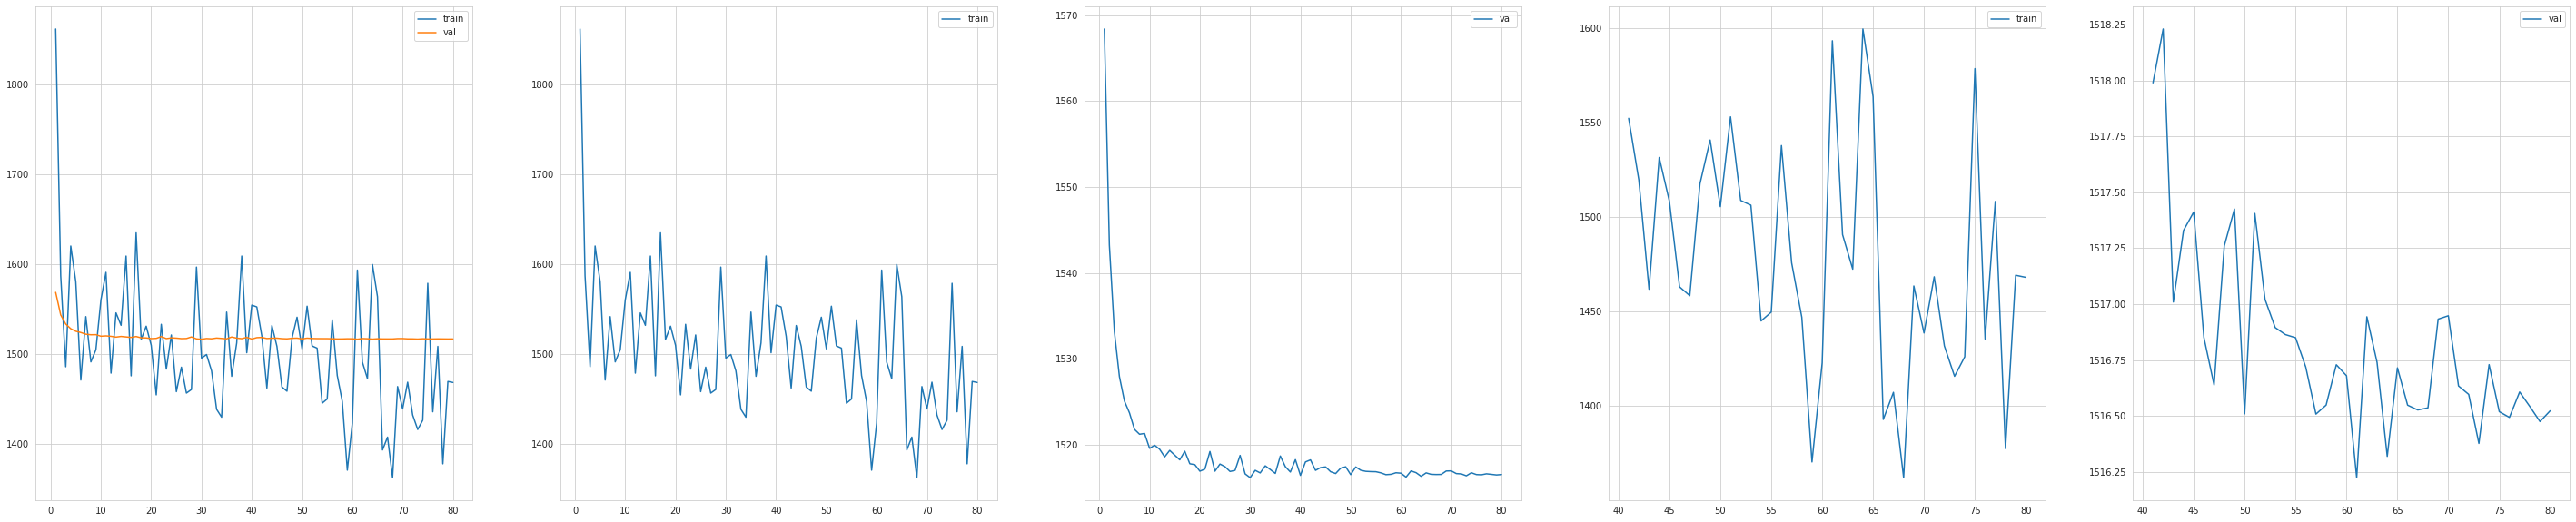

In [11]:
if out is not None:
    fig, ax = plt.subplots(1,5,figsize=(50,10))
    ax[0].plot((np.arange(len(out[1][0]))+1), out[1][0], label="train")
    ax[0].plot((np.arange(len(out[1][0]))+1), out[1][1], label="val")
    ax[1].plot((np.arange(len(out[1][0]))+1), out[1][0], label="train")
    ax[2].plot((np.arange(len(out[1][0]))+1), out[1][1], label="val")
    ax[3].plot((np.arange(len(out[1][0]))+1)[40:], out[1][0][40:], label="train")
    ax[4].plot((np.arange(len(out[1][0]))+1)[40:], out[1][1][40:], label="val")
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[3].legend()
    ax[4].legend()
    plt.show()

In [14]:
print(model)

FlowFA_Ident(
  (encoding_model): Encoder(
    (core): SE2dCore(
      (_input_weights_regularizer): LaplaceL2norm(
        (laplace): Laplace()
      )
      (features): Sequential(
        (layer0): Sequential(
          (conv): Conv2d(1, 64, kernel_size=(15, 15), stride=(1, 1), bias=False)
          (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
          (nonlin): ELU(alpha=1.0, inplace=True)
        )
        (layer1): Sequential(
          (ds_conv): DepthSeparableConv2d(
            (in_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (spatial_conv): Conv2d(64, 64, kernel_size=(13, 13), stride=(1, 1), padding=(6, 6), groups=64, bias=False)
            (out_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
          (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
          (nonlin): ELU(alpha=1.0, inplace=True)
        )
     

In [15]:
from utility_extended import *

In [16]:
print(f"Train loss: {calcLossForDataset(model, dataloaders['train'], 1000, True)}\nVal loss: {calcLossForDataset(model, dataloaders['validation'], 1000, True)}\nTest loss: {calcLossForDataset(model, dataloaders['test'], 1000, True)}")

Train loss: 2.048510422459386
Val loss: 1.990503692516503
Test loss: 1.9915509566574845


In [17]:
torch.save(model, "./models/FlowFA-Ident-LowRank")